# CUNY DATA 604 - Final Project Summer 2021
---
## Solar Panel Simulation for Livingston Manor, NY

**Jeff Shamp**

In [2]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import math
from modsim import *
import seaborn as sns

sns.set_style('darkgrid')

### Problem

Battling climate change with have to take place on multiple fronts for macro-scale decisions by governments around the world, as well as smaller localities and individuals. The foremost decision to make is to transition away from fossil fuels at every level. As a homeowner, switching to solar energy is the primary way to supple this mission. The issue with switching to solar is making sure there is an external incentitive for homeowners to swtich. The cost of solar is sustaination, but with the right context it can be a good choice now. 

That context includes; solar panel efficiency, tax rebates and credits, electrical usage, and surface area for the solar array. The purpose of this project is to determine the viability of switching solar for an individual home in the Catskills of New York. We will examine and simulate several parameters for a given location and make some reasonable assuming for unknown values to model the financial viablity of a solar switch. 

## Process Flowchart

![Solar Process](Slide1.jpg)

#### Data

The sunlight data for this project was pulled the National Solar Radiation Database [NSRD](https://nsrdb.nrel.gov/about/what-is-the-nsrdb.html). The site has a nice API for requesting data based on location. We used the GPS coordinate for the home using [Google Earth](https://earth.google.com/web/@41.89294261,-74.86049298,636.21141602a,82.31968843d,35y,0h,0t,0r). We also used Google to estimate the usable, south-facing roof surface area. 

In [3]:
################### The follow code is from the NREL API website. ####################
################### This is their suggested method of data access  ###################

# Declare all variables as strings. Spaces must be replaced with '+',
#i.e., change 'John Smith' to 'John+Smith'.
# Define the lat, long of the location and the year
lat, lon, year = 41.89301649264991, -74.86044454476131, 2020
# You must request an NSRDB api key from the link above
api_key = '0UnkPEMlXjBwlZ3WXwXdnaGSn5ozGnKO75uyZ9JI'
# Set the attributes to extract (e.g., dhi, ghi, etc.), separated by commas.
attributes = 'ghi,dhi,dni,wind_speed,air_temperature,solar_zenith_angle'
# Choose year of data
year = '2020'
# Set leap year to true or false. True will return leap day data if present, false will not.
leap_year = 'false'
# Set time interval in minutes, i.e., '30' is half hour intervals. Valid intervals are 30 & 60.
interval = '60'
# Specify Coordinated Universal Time (UTC), 'true' will use UTC,
#'false' will use the local time zone of the data.
# NOTE: In order to use the NSRDB data in SAM, you must specify UTC as 'false'.
#SAM requires the data to be in the
# local time zone.
utc = 'false'
# Your full name, use '+' instead of spaces.
your_name = 'John+Smith'
# Your reason for using the NSRDB.
reason_for_use = 'beta+testing'
# Your affiliation
your_affiliation = 'my+institution'
# Your email address
your_email = 'user@nrel.gov'
# Please join our mailing list so we can keep you up-to-date on new developments.
mailing_list = 'true'

# Declare url string
### Make it PEP 8 ###
url_1 = 'https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-download.csv'
url_2 = '?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}'
url_3 = '&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}'
url_4 = '&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'
url_total = url_1+url_2+url_3+url_4
url = url_total.format(year=year, lat=lat, lon=lon, leap=leap_year, 
                 interval=interval, utc=utc, name=your_name,
                 email=your_email, mailing_list=mailing_list, 
                 affiliation=your_affiliation, 
                 reason=reason_for_use, api=api_key, attr=attributes)
# Return just the first 2 lines to get metadata:
meta_info = pd.read_csv(url,nrows=1)
# See metadata for specified properties, e.g., timezone and elevation
timezone, elevation = meta_info['Local Time Zone'], meta_info['Elevation']

In [4]:
years = ['20'+f'{i}' for i in range(16,21,1)]
df_list = []
for y in years:
    url = url_total.format(year=y, lat=lat, lon=lon, leap=leap_year, 
                 interval=interval, utc=utc, name=your_name,
                 email=your_email, mailing_list=mailing_list, 
                 affiliation=your_affiliation, 
                 reason=reason_for_use, api=api_key, attr=attributes)
    df_list.append(pd.read_csv(url, skiprows=2))
df = pd.concat(df_list, axis=0)

In [5]:
write_csv = False
if write_csv:
    df.to_csv("solar_data_manor.csv")

Below we have the resulting data from the API. We will use the GHI data from this data set and include it standard deviation for this simulation. A sample of the data is shown below. 

In [6]:
meta_info[['Longitude', 'Time Zone', 'Elevation', 'Local Time Zone',
       'Clearsky DHI Units', 'Clearsky DNI Units', 'Clearsky GHI Units',
       'Dew Point Units', 'DHI Units', 'DNI Units', 'GHI Units',
       'Solar Zenith Angle Units', 'Temperature Units', 'Pressure Units',
       'Relative Humidity Units', 'Precipitable Water Units']]

,Longitude,Time Zone,Elevation,Local Time Zone,Clearsky DHI Units,Clearsky DNI Units,Clearsky GHI Units,Dew Point Units,DHI Units,DNI Units,GHI Units,Solar Zenith Angle Units,Temperature Units,Pressure Units,Relative Humidity Units,Precipitable Water Units
0,-74.86,-5,608,-5,w/m2,w/m2,w/m2,c,w/m2,w/m2,w/m2,Degree,c,mbar,%,cm


In [7]:
df.sample(10)

,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
6314,2019,9,21,2,30,0,0,0,0.9,11.1,124.53
6858,2020,10,13,18,30,0,0,0,0.0,11.3,103.76
2879,2020,4,30,23,30,0,0,0,0.0,10.2,122.58
2599,2016,4,19,7,30,185,165,48,0.1,7.0,65.41
2630,2018,4,20,14,30,493,328,232,0.1,2.4,44.72
4936,2018,7,25,16,30,98,98,0,0.0,21.5,59.43
3684,2018,6,3,12,30,273,258,16,0.0,16.2,20.66
3191,2018,5,13,23,30,0,0,0,0.0,7.5,119.22
98,2020,1,5,2,30,0,0,0,1.1,-3.1,144.15
6720,2019,10,8,0,30,0,0,0,0.0,8.9,142.66


Here are the GHI and corresponding standard devations for each month. 

In [8]:
temp = df[['Month','Day','GHI']]
daily = temp.groupby(['Month','Day']).sum()
monthly_mean = daily.groupby(['Month']).mean()
monthly_sd = daily.groupby(['Month']).std()
monthly=pd.DataFrame(monthly_mean)
monthly['STD']=monthly_sd['GHI']
monthly

,GHI,STD
Month,,
1,9262.645161,1797.450297
2,13884.107143,2968.560149
3,20266.483871,3849.941072
4,22409.766667,4350.489292
5,25068.032258,5689.287445
6,31024.433333,5526.904800
7,30864.354839,3866.970085
8,26886.451613,4303.807182
9,20787.833333,3900.749955


Now we will define a simple system for simulating the power generate for a given solar array. This system will track the loss/gain in power balance over a specified timeline, in this case below, ten years. 

In [9]:
def define_system(A,lat,long,r=0.175,PR=0.8):
    '''Create a system object defining our solar panel system
    
    A -    surface area of the panels (in m^2)
    r -    solar panel efficiency (between 15 and 21%, default 17.5%)
    PR -   performance ratio (between 50 and 90%, default 80%
    lat -  latitude of the location
    long - longitude of the location
    
    returns: System object
    '''
    
    start = State(P=0, N=0, B=0)
    
    ''' Create a state tracking the months as well as the power balance
    P -    number of months where more power was generated than used
    N -    number of months where less power was generated than used
    B -    overall balance of power
    '''
    
    t0 = 0
    '''10 years of operation'''
    t_end = 10*12
    
    return System(start=start, t0=t0, t_end=t_end, A=A, r=r, PR=PR, lat=lat, long=long)

## Define Yield and Demand for Manor

We also need to define the yield and demand for household. Below are two functions; `days_yield` takes a normal distribtion of the GHI data for a given month and `days_demand` estimates the daily demand for electricity at the home. For the demand, we do not have a great estimate for the home. The power company only takes an actual reading once every 4 months and we have not owned the place for an entire year. Based on the usage and the uncertainity, we estimate the demand is around 20kWh/day. We will have a large standard deviation to try to encapulate the current uncertainity in demand.

In [24]:
def days_yield(system,month):
    month = month
    ghi_day = np.random.normal(monthly.iloc[month-1]['GHI'],
                               monthly.iloc[month-1]['STD'])
    if ghi_day < 0:
        ghi_day = 0
    return (system.A*system.r*ghi_day*system.PR)/1000

def days_demand_norm(mean = 20, std = 9):
    demand_day = np.random.normal(mean,std)
    if demand_day < 0:
        demand_day = 0
    return demand_day

days_demand_norm()

18.727063300614702

The following function calculates the daily gain and loss based on the above estimation functions. 

In [25]:
def calc_day(system,month):
    gain = days_yield(system,month)
    loss = days_demand_norm()
    return gain - loss, loss

Once those values are created we need to have a meaningful demand for each month of the year keeping the length of the each month into consideration. 

In [26]:
def calc_month(system, month):
    month = (month % 12)+1
    mon_31 = [1,3,5,7,8,10,12]
    mon_30 = [4,6,9,11]
    if month in mon_31:
        days = 31
    elif month in mon_30:
        days = 30
    elif month == 2:
        days = 28
    else:
        print("Invalid month number. Select 1-12")
        return None
    p = 0
    n = 0
    balance = 0
    c = 0
    for day in range(1,days+1):
        net, loss = calc_day(system,month)
        balance += net
        c += loss
    if balance >= 0:
        p = 1
    else:
        n = 1
    
    this_month = State(P=p, N=n, 
                       B=balance, C = c)
    return this_month

Now the update function to track the monthly demand. 

In [27]:
def update_func(state,system,month):
    '''Update the power balance of the model.
    
    state: State with variables P, N, B
    system: System with relevant info
    '''
    p, n, b = state
    
    month_result = calc_month(system, month)
    
    p += month_result.P
    n += month_result.N
    b += month_result.B
          
    return State(P=int(p), N=int(n), B=b)

Define the simulation given the above functions.

In [28]:
def run_simulation(system,update_func):
    """ Use system feature to update the state.
    
    system - system object defining panels
    update_func - function describing change to system 
    
    returns - Timeseries
    """
    P = TimeSeries()
    N = TimeSeries()
    B = TimeSeries()
    
    state = system.start
    t0 = system.t0
    P[t0], N[t0], B[t0] = state
    
    for t in linrange(system.t0, system.t_end):
        state = update_func(state,system,t)
        P[t+1], N[t+1], B[t+1] = state
    
    return P, N, B

Let's run a test and plot the results!

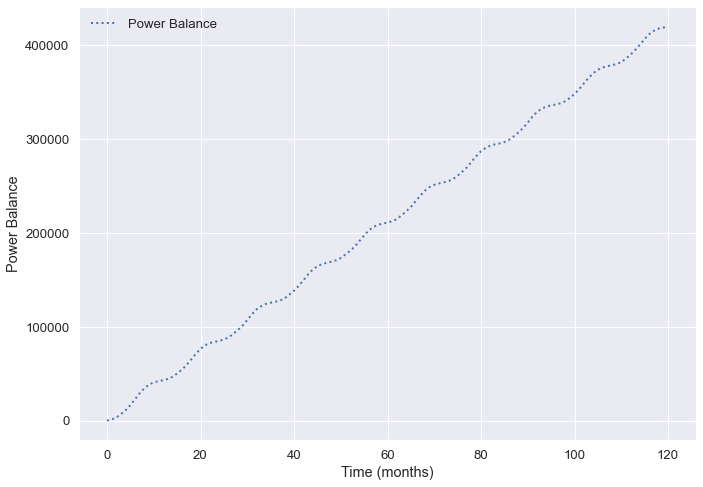

In [29]:
lat = 41.89301649264991
long = -74.86044454476131

fig = plt.figure(figsize=(10,7))

system = define_system(A=50, lat=lat, long=long)
P, N, B = run_simulation(system,update_func)
plot(B, ':', label='Power Balance')
decorate(xlabel='Time (months)',
    ylabel='Power Balance')

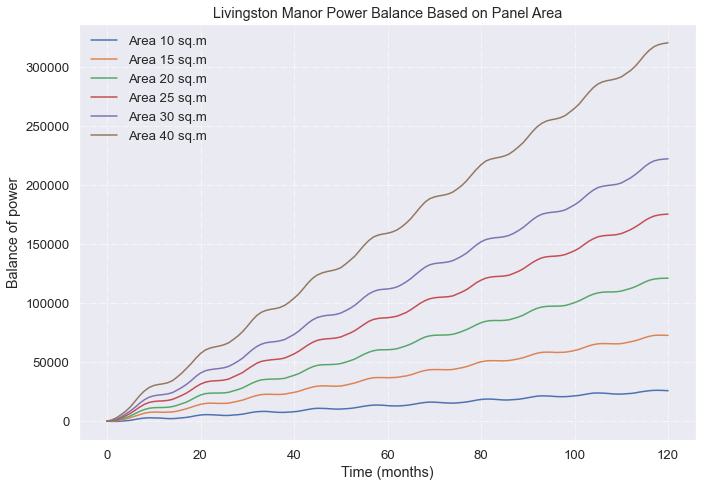

In [30]:
fig = plt.figure(figsize=(10,7))

for area in [10,15,20,25,30,40]:
    system = define_system(A=area, lat=lat, long=long)
    P, N, B = run_simulation(system,update_func)
    plt.plot(B, label =f'Area {area} sq.m')
decorate(xlabel='Time (months)',
    ylabel='Balance of power',
    title='Livingston Manor Power Balance Based on Panel Area')
plt.grid(b=True,alpha = 0.6, linestyle='dashdot')

These numbers look really good but we are not taking into account the cost of the system of the cost of the electrical usage without the solar array. These results also suggest that the needed surface area of the solar panels can be much less given the estimate electrical usage. 

#### Include Solar Cost

We will now amend the simualation to include the cost of the solar panels. In upstate New York, most solar installs average about \\$14,000 to \\$20,000, with an average up-front cost of around \\$17,000. Luckily, the state and federal goverment incentivize solar systems. Thus, it is possible to get up to 51% of the cost of installing solar panels on a home back in tax credit, rebates, deductions, etc. Since that is not a guarantee, we will assume the full the cost of the install to pay back. 

In [31]:
def define_system_2(A,lat,long,initial_cost,r = 0.175,PR=0.8):
    '''Create a system object defining our solar array
    
    A -    surface area of the panels (in m^2)
    r -    solar panel efficiency (between 15 and 21%, default 17.5%)
    PR -   performance ratio (between 50 and 90%, default 80%
    lat -  latitude of the location
    long - longitude of the location
    
    returns: System object
    '''
    start = State(P=0, N=0, PB=0, FB = -initial_cost, C=0)
    '''Create a state tracking the positive/negative months, and balance overall
    P -    number of months where more power was generated than used
    N -    number of months where less power was generated than used
    PB -   overall balance of power
    FB -   overall financial expenditure
    C -    power Consumption
    '''
    t0 = 0
    '''20 years worth of operation'''
    t_end = 20*12
    # drop state selection
    return System(start=start, t0=t0, t_end=t_end, A=A, r=r, PR=PR, lat=lat, long=long)

In [32]:
def update_func_2(state,system,month):
    '''Update the pos/neg/balance model.
    
    state: State with variables P, N, PB, FB, C
    system: System with relevant info
    '''
    p, n, pb, fb, c = state
    
    price = .05894459
    
    month_result = calc_month(system, month)
    
    p += month_result.P
    n += month_result.N
    pb += month_result.B
    fb += month_result.B * price
    c += month_result.C * price
          
    return State(P=int(p), N=int(n), PB=pb, FB = fb, C = c)

In [33]:
def run_simulation_2(system,upd_fxn):
    """Take a system as input and unpdate it based on the update function.
    
    system - system object defining panels
    update_fxn - function describing change to system 
    
    returns - Timeseries
    """
    P = TimeSeries()
    N = TimeSeries()
    PB = TimeSeries()
    FB = TimeSeries()
    C = TimeSeries()
    
    state = system.start
    t0 = system.t0
    P[t0], N[t0], PB[t0], FB[t0], C[t0] = state
    
    for t in linrange(system.t0, system.t_end):
        state = upd_fxn(state,system,t)
        P[t+1], N[t+1], PB[t+1], FB[t+1], C[t+1] = state
    
    return P, N, PB, FB, -C

We defined a similar system and simulation to view the pay back time line for a \\$17,000 installation given our estimate electrical usage.

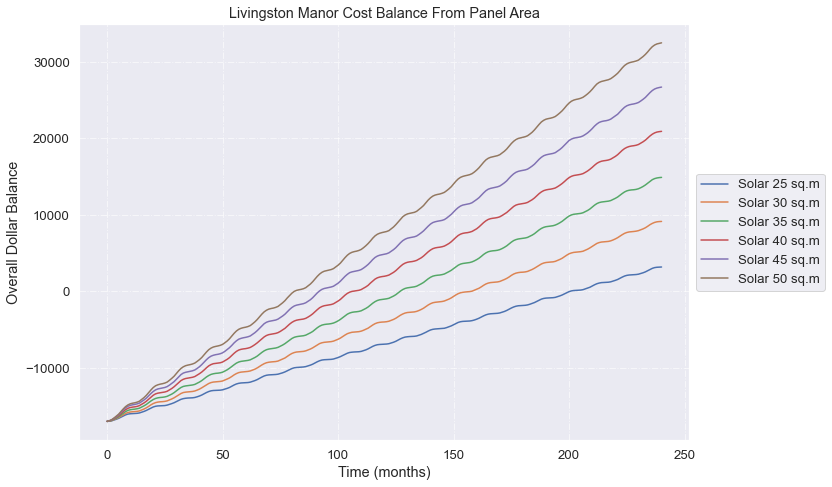

In [34]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)

for area in [25,30,35,40,45,50]:
    system = define_system_2(A=area, lat=lat, long=long, initial_cost = 17000)
    P, N, PB, FB, C = run_simulation_2(system,update_func_2)
    ax.plot(FB, label = f'Solar {area} sq.m')

decorate(xlabel='Time (months)',
    ylabel='Overall Dollar Balance',
    title='Livingston Manor Cost Balance From Panel Area')
ax.grid(b=True,alpha = 0.6, linestyle='dashdot')
# Shrink current axis's height by 10% on the bottom
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Depending on the size of the array, we are looking at approximately 4.5 to 16 year pay off interval for this array. This does not include the money saved by not paying NYSEG for electricity. 

Below, we will add the cost savings of what-would-be electric costs if no solar system were put in place. We pay \\$0.05894459 per kWh from NYSEG.

It should be noted that the area values are simply guessed. Using [Google Earth](https://earth.google.com/web/@41.89294261,-74.86049298,636.21141602a,82.31968843d,35y,0h,0t,0r) for our location we are able to estimate a potential surface for the panels based on the area of our roof. It seems reasonable that a surface area of 30-45 $m^{2}$ can be placed on our roof.

Given this information, we can create the most reasonable simulation for the cost of the solar panels based on the data we have available to us. 

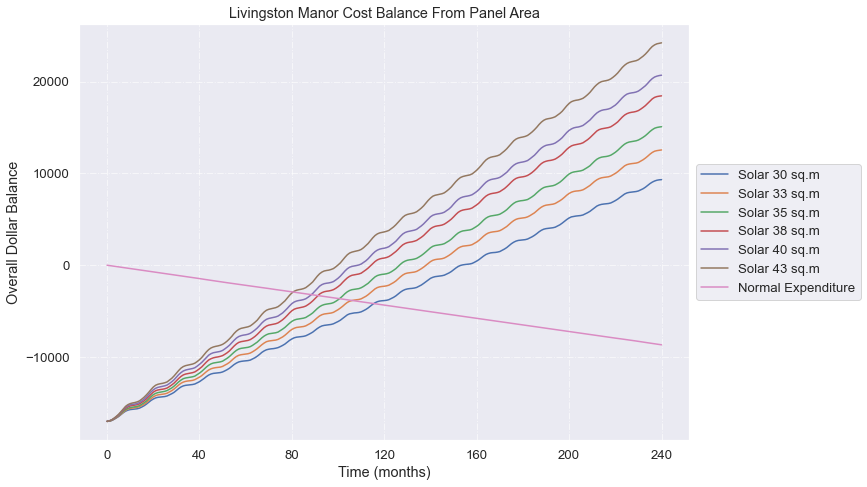

In [35]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)

for area in [30,33,35,38,40,43]:
    system = define_system_2(A=area, lat=lat, long=long, initial_cost = 17000)
    P, N, PB, FB, C = run_simulation_2(system,update_func_2)
    ax.plot(FB, label = f'Solar {area} sq.m')
ax.plot(C, label = "Normal Expenditure")
decorate(xlabel='Time (months)',
    ylabel='Overall Dollar Balance',
    title='Livingston Manor Cost Balance From Panel Area')
ax.set_xticks(np.linspace(0,20*12,7))
ax.grid(b=True,alpha = 0.6, linestyle='dashdot')

# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Based on the plot above, we can expect to be energy cost free in 7-10 years given the information provided above. 

#### More Efficient Panels

One other option to consider is purchasing a more efficient panel. Newer panel have upto r=0.21. We ran another simulation at $A=38m^{2}$ with a range of r-values to see if the pay back period would be significantly lower. 

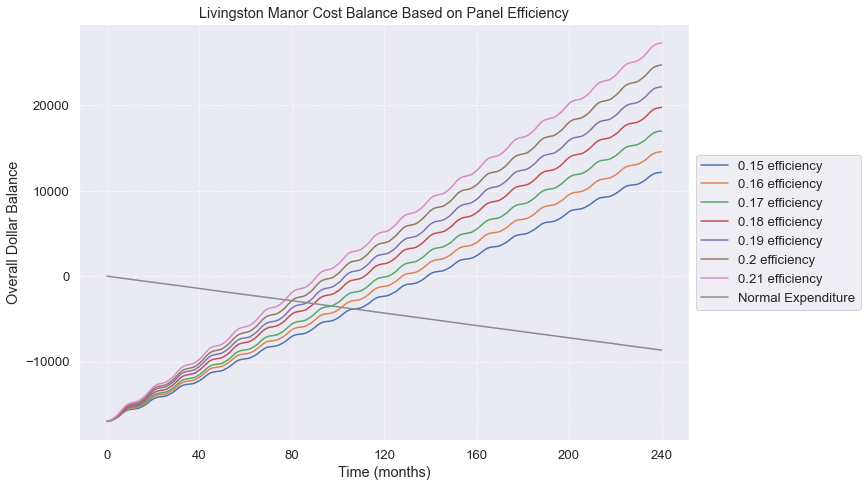

In [36]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)

for r in [0.15,0.16,0.17, 0.18,0.19,0.20,0.21]:
    system = define_system_2(A=38, lat=lat, long=long, initial_cost = 17000, r=r)
    P, N, PB, FB, C = run_simulation_2(system,update_func_2)
    ax.plot(FB, label = f'{r} efficiency')
ax.plot(C, label = "Normal Expenditure")
decorate(xlabel='Time (months)',
    ylabel='Overall Dollar Balance',
    title='Livingston Manor Cost Balance Based on Panel Efficiency')
ax.set_xticks(np.linspace(0,20*12,7))
ax.grid(b=True,alpha = 0.6, linestyle='dashdot')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

From this, it seems that paying extra for a higher r-value, would not significantly lower the pay back period. It might get us an extra year at the maximum. 

### Future Work

1) Get a better sense of projected electrical demand for the house. 
2) Wrap this simulation framework into a Bokeh interactive website for high customization. 
3) Add roofing costs associated with solar (moss grows here in any shaded place)